In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/DL/'
#path ='Dataset/'

In [0]:
import torch, torchvision, os
import torch.nn as nn
import torch.optim as optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.functional as F
import spectral as SN
import block as B
from collections import OrderedDict

In [0]:
import math, time, random, functools, util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
class RRDBNet(nn.Module):
    def __init__(self, in_nc, out_nc, nf, nb, gc=32, upscale=4, norm_type=None, \
            act_type='leakyrelu', mode='CNA', upsample_mode='upconv'):
        super(RRDBNet, self).__init__()
        n_upscale = int(math.log(upscale, 2))
        if upscale == 3:
            n_upscale = 1

        fea_conv = B.conv_block(in_nc, nf, kernel_size=3, norm_type=None, act_type=None)
        rb_blocks = [B.RRDB(nf, kernel_size=3, gc=32, stride=1, bias=True, pad_type='zero', \
            norm_type=norm_type, act_type=act_type, mode='CNA') for _ in range(nb)]
        LR_conv = B.conv_block(nf, nf, kernel_size=3, norm_type=norm_type, act_type=None, mode=mode)

        if upsample_mode == 'upconv':
            upsample_block = B.upconv_blcok
        elif upsample_mode == 'pixelshuffle':
            upsample_block = B.pixelshuffle_block
        else:
            raise NotImplementedError('upsample mode [{:s}] is not found'.format(upsample_mode))
        if upscale == 3:
            upsampler = upsample_block(nf, nf, 3, act_type=act_type)
        else:
            upsampler = [upsample_block(nf, nf, act_type=act_type) for _ in range(n_upscale)]
        HR_conv0 = B.conv_block(nf, nf, kernel_size=3, norm_type=None, act_type=act_type)
        HR_conv1 = B.conv_block(nf, out_nc, kernel_size=3, norm_type=None, act_type=None)

        self.model = B.sequential(fea_conv, B.ShortcutBlock(B.sequential(*rb_blocks, LR_conv)),\
            *upsampler, HR_conv0, HR_conv1)

    def forward(self, x):
        x = self.model(x)
        return x


In [0]:
class Discriminator_VGG_128(nn.Module):
    def __init__(self, in_nc, base_nf, norm_type='batch', act_type='leakyrelu', mode='CNA'):
        super(Discriminator_VGG_128, self).__init__()
        # features
        # hxw, c
        # 128, 64
        conv0 = B.conv_block(in_nc, base_nf, kernel_size=3, norm_type=None, act_type=act_type, \
            mode=mode)
        conv1 = B.conv_block(base_nf, base_nf, kernel_size=4, stride=2, norm_type=norm_type, \
            act_type=act_type, mode=mode)
        # 64, 64
        conv2 = B.conv_block(base_nf, base_nf*2, kernel_size=3, stride=1, norm_type=norm_type, \
            act_type=act_type, mode=mode)
        conv3 = B.conv_block(base_nf*2, base_nf*2, kernel_size=4, stride=2, norm_type=norm_type, \
            act_type=act_type, mode=mode)
        # 32, 128
        conv4 = B.conv_block(base_nf*2, base_nf*4, kernel_size=3, stride=1, norm_type=norm_type, \
            act_type=act_type, mode=mode)
        conv5 = B.conv_block(base_nf*4, base_nf*4, kernel_size=4, stride=2, norm_type=norm_type, \
            act_type=act_type, mode=mode)
        # 16, 256
        conv6 = B.conv_block(base_nf*4, base_nf*8, kernel_size=3, stride=1, norm_type=norm_type, \
            act_type=act_type, mode=mode)
        conv7 = B.conv_block(base_nf*8, base_nf*8, kernel_size=4, stride=2, norm_type=norm_type, \
            act_type=act_type, mode=mode)
        # 8, 512
        conv8 = B.conv_block(base_nf*8, base_nf*8, kernel_size=3, stride=1, norm_type=norm_type, \
            act_type=act_type, mode=mode)
        conv9 = B.conv_block(base_nf*8, base_nf*8, kernel_size=4, stride=2, norm_type=norm_type, \
            act_type=act_type, mode=mode)
        # 4, 512
        self.features = B.sequential(conv0, conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8,\
            conv9)

        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 100), nn.LeakyReLU(0.2, True), nn.Linear(100, 1))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [0]:
class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layer=34, use_bn=False, use_input_norm=True):
        super(VGGFeatureExtractor, self).__init__()
        if use_bn:
            model = torchvision.models.vgg19_bn(pretrained=True)
        else:
            model = torchvision.models.vgg19(pretrained=True)
        self.use_input_norm = use_input_norm
        if self.use_input_norm:
            mean = torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).cuda()
            std = torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).cuda()
            self.register_buffer('mean', mean)
            self.register_buffer('std', std)
        self.features = nn.Sequential(*list(model.features.children())[:(feature_layer + 1)])
        for k, v in self.features.named_parameters():
            v.requires_grad = False

    def forward(self, x):
        if self.use_input_norm:
            x = (x - self.mean) / self.std
        output = self.features(x)
        return output


In [0]:
def define_G():
  
    G = RRDBNet(in_nc=3, out_nc=3, nf=64, nb=23, upscale=4,
                   act_type='leakyrelu', mode='CNA', upsample_mode='upconv')
    init_weights(G, init_type='kaiming', scale=0.1)
    return G

def define_D():
    D = Discriminator_VGG_128(in_nc=3, base_nf=64, norm_type='batch', mode="CNA", act_type='leakyrelu')
    init_weights(D, init_type='kaiming', scale=1)
    return D

def define_F(use_bn=False):
    if use_bn:
        feature_layer = 49
    else:
        feature_layer = 34
    F = VGGFeatureExtractor(feature_layer=feature_layer, use_bn=use_bn, \
                                use_input_norm=True)
    F.eval()
    return F

In [0]:
def weights_init_kaiming(m, scale=1):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        m.weight.data *= scale
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        m.weight.data *= scale
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.constant_(m.weight.data, 1.0)
        init.constant_(m.bias.data, 0.0)

In [0]:
def init_weights(net, init_type='kaiming', scale=1, std=0.02):
    if init_type == 'normal':
        weights_init_normal_ = functools.partial(weights_init_normal, std=std)
        net.apply(weights_init_normal_)
    elif init_type == 'kaiming':
        weights_init_kaiming_ = functools.partial(weights_init_kaiming, scale=scale)
        net.apply(weights_init_kaiming_)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [{:s}] not implemented'.format(init_type))


In [0]:
class GANLoss(nn.Module):
    def __init__(self, gan_type, real_label_val=1.0, fake_label_val=0.0):
        super(GANLoss, self).__init__()
        self.gan_type = gan_type.lower()
        self.real_label_val = real_label_val
        self.fake_label_val = fake_label_val

        if self.gan_type == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif self.gan_type == 'lsgan':
            self.loss = nn.MSELoss()
        elif self.gan_type == 'wgan-gp':

            def wgan_loss(input, target):
                return -1 * input.mean() if target else input.mean()

            self.loss = wgan_loss
        else:
            raise NotImplementedError('GAN type [{:s}] is not found'.format(self.gan_type))

    def get_target_label(self, input, target_is_real):
        if self.gan_type == 'wgan-gp':
            return target_is_real
        if target_is_real:
            return torch.empty_like(input).fill_(self.real_label_val)
        else:
            return torch.empty_like(input).fill_(self.fake_label_val)

    def forward(self, input, target_is_real):
        target_label = self.get_target_label(input, target_is_real)
        loss = self.loss(input, target_label)
        return loss


class GradientPenaltyLoss(nn.Module):
    def __init__(self, device=torch.device('cpu')):
        super(GradientPenaltyLoss, self).__init__()
        self.register_buffer('grad_outputs', torch.Tensor())
        self.grad_outputs = self.grad_outputs.to(device)

    def get_grad_outputs(self, input):
        if self.grad_outputs.size() != input.size():
            self.grad_outputs.resize_(input.size()).fill_(1.0)
        return self.grad_outputs

    def forward(self, interp, interp_crit):
        grad_outputs = self.get_grad_outputs(interp_crit)
        grad_interp = torch.autograd.grad(outputs=interp_crit, inputs=interp, \
            grad_outputs=grad_outputs, create_graph=True, retain_graph=True, only_inputs=True)[0]
        grad_interp = grad_interp.view(grad_interp.size(0), -1)
        grad_interp_norm = grad_interp.norm(2, dim=1)

        loss = ((grad_interp_norm - 1)**2).mean()
        return loss

In [0]:
pixel_weight = 1e-2
feature_weight = 1
gan_type = 'vanilla'
gan_weight = 5e-3
D_update_ratio = 1
D_init_iters = 0
gp_weight = 10
weight_decay_G = 0
weight_decay_D = 0
beta_G = 0.9
beta_D = 0.9
lr_gamma = 0.5
lr_steps = [50000, 100000, 200000, 300000]

In [0]:
loss_plot = []

In [0]:
class ESRGAN():
    def __init__(self):
        super(ESRGAN, self).__init__()

        self.G = define_G().cuda()  
        self.D = define_D().cuda() 
        self.G.train()
        self.D.train()
        if pixel_weight > 0:
            self.pixel_loss = nn.L1Loss().cuda()
            #self.pixel_loss = nn.MSELoss().cuda()
            self.pixel_wt = pixel_weight
        else:
            self.pixel_loss = None
        if feature_weight > 0:
            self.feature_loss = nn.L1Loss().cuda()
            #self.feature_loss = nn.MSELoss().cuda()
            self.feature_wt = feature_weight
        else:
            self.feature_loss = None
        
        if self.feature_loss: 
            self.F = define_F(use_bn=False).cuda()

        self.gan_loss = GANLoss(gan_type, 1.0, 0.0).cuda()
        self.gan_wt = gan_weight
        self.D_update_ratio = D_update_ratio 
        self.D_init_iters = D_init_iters 

        wd_G = weight_decay_G 
        optim_params = []
        optimizers = []
        self.schedulers = []
        for k, v in self.G.named_parameters():  
            if v.requires_grad:
                optim_params.append(v)
        self.optimizer_G = torch.optim.Adam(optim_params, lr=1e-4, weight_decay=wd_G, betas=(beta_G, 0.999))
        optimizers.append(self.optimizer_G)

        wd_D = weight_decay_D 
        self.optimizer_D = torch.optim.Adam(self.D.parameters(), lr=1e-4, weight_decay=wd_D, betas=(beta_D, 0.999))
        optimizers.append(self.optimizer_D)

      
        for optimizer in optimizers:
            self.schedulers.append(lr_scheduler.MultiStepLR(optimizer, lr_steps, lr_gamma))

    def update_learning_rate(self):
        for scheduler in self.schedulers:
            scheduler.step()
    
    def feed_data(self, data, need_HR=True):

        self.var_L = data['LR'].cuda()
        if need_HR: 
            self.var_H = data['HR'].cuda()

            input_ref = data['ref'] if 'ref' in data else data['HR']
            self.var_ref = input_ref.cuda()

    def optimize_parameters(self, step):
        self.optimizer_G.zero_grad()
        self.fake_H = self.G(self.var_L)

        l_g_total = 0
        if step % self.D_update_ratio == 0 and step > self.D_init_iters:
            if self.pixel_loss:  # pixel loss
                G_pixel_loss = self.pixel_wt * self.pixel_loss(self.fake_H, self.var_H)
                l_g_total += G_pixel_loss
            if self.feature_loss:  # feature loss
                real_fea = self.F(self.var_H).detach()
                fake_fea = self.F(self.fake_H)
                G_feature_loss = self.feature_wt * self.feature_loss(fake_fea, real_fea)
                l_g_total += G_feature_loss
            pred_g_fake = self.D(self.fake_H)
            l_g_gan = self.gan_wt * self.gan_loss(pred_g_fake, True)
            l_g_total += l_g_gan
            
            l_g_total.backward()
            self.optimizer_G.step()
            return l_g_total
 
        self.optimizer_D.zero_grad()
        l_d_total = 0

        pred_d_real = self.D(self.var_ref)
        l_d_real = self.gan_loss(pred_d_real, True)

        pred_d_fake = self.D(self.fake_H.detach())
        l_d_fake = self.gan_loss(pred_d_fake, False)

        l_d_total = (l_d_real+l_d_fake)
        
        l_d_total.backward()
        self.optimizer_D.step()

        
    def test(self):
        self.G.eval()
        with torch.no_grad():
            self.fake_H = self.G(self.var_L)
        self.G.train()

    def get_current_visuals(self, need_HR=True):
        out_dict = OrderedDict()
        out_dict['LR'] = self.var_L.detach()[0].float().cpu()
        out_dict['SR'] = self.fake_H.detach()[0].float().cpu()
        if need_HR:
            out_dict['HR'] = self.var_H.detach()[0].float().cpu()
        return out_dict
    def save(self, iter_step):
        self.save_network(self.netG, 'G', iter_step)
        self.save_network(self.netD, 'D', iter_step)


In [50]:
model = ESRGAN()

L1Loss()


In [0]:
def create_dataset(dataset_opt):
    from LRHR_dataset import LRHRDataset as D
    dataset = D(dataset_opt)  
    return dataset

In [0]:
train_set_opt = {
      "name": "DIV2K" 
      , "dataroot_HR": '/content/drive/My Drive/DL/train_HR'
      , "dataroot_LR": '/content/drive/My Drive/DL/train_LR'
      , "use_shuffle": True 
      , "n_workers": 8 
      , "batch_size": 10
      , "HR_size": 128 
      , "use_flip": True 
      , "use_rot": True 
      , "phase": "train"
      , "scale": 4
      , "data_type": "img"
      , "subset_file": None
    }

In [0]:
val_set_opt = { 
      "name": "val_set5"
      , "mode": "LRHR"
      , "dataroot_HR": '/content/drive/My Drive/DL/val_HR'
      , "dataroot_LR": '/content/drive/My Drive/DL/val_LR'
      , "data_type": "img"
      , "phase": "val"
      , "scale": 4
      , "HR_size": 128
    }

In [0]:
train_set = create_dataset(train_set_opt)
val_set = create_dataset(val_set_opt)

In [0]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=0, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True, num_workers=0)

In [60]:
max_iter = 0
total_iters=2e3
for epoch in range(0, 10000):
    max_iter = 0
    loss_epoch = 0
    print ("Epoch:",epoch)
    for _, train_data in enumerate(train_loader):
        max_iter += 1
        if (max_iter%10==0):
            print (max_iter)
        if (max_iter > 10000):
            break
       
        # update learning rate
        model.update_learning_rate()

        # training
        model.feed_data(train_data)
        loss_epoch += model.optimize_parameters(max_iter).data.cpu().numpy()

        # validation
        if (epoch % 100 == 0):
            loss_plot.append(loss_epoch/10)
            avg_psnr = 0.0
            idx = 0
            for val_data in val_loader:
                idx += 1 
                model.feed_data(val_data)
                model.test()
                visuals = model.get_current_visuals()
                sr_img = util.tensor2img(visuals['SR'])  # uint8
                gt_img = util.tensor2img(visuals['HR'])  # uint8

                # Save SR images for reference
                save_img_path = os.path.join(path+'SR/', str(epoch)+'_'+str(max_iter)+'.png')
                util.save_img(sr_img, save_img_path)

                # calculate PSNR
                crop_size = 4
                gt_img = gt_img/255.
                sr_img = sr_img/255.
                cropped_sr_img = sr_img[crop_size:-crop_size, crop_size:-crop_size, :]
                cropped_gt_img = gt_img[crop_size:-crop_size, crop_size:-crop_size, :]
                avg_psnr += util.calculate_psnr(cropped_sr_img * 255, cropped_gt_img * 255)

            avg_psnr = avg_psnr / idx
            psnr_plot.append(avg_psnr)

Epoch: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1

KeyboardInterrupt: ignored

In [0]:
state_dict = model.G.state_dict()
torch.save(state_dict, path+'GeneratorX.pth')

In [87]:
!ls '/content/drive/My Drive/DL/'

Dataset.zip    Octopus	train_HR  Train_Valid_LR.zip  val_LR
Generator.pth  SR	train_LR  val_HR


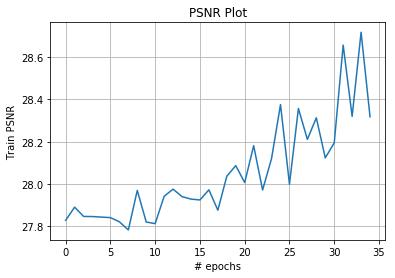

In [78]:
x = range(35)
plt.plot(x, psnr_plot)
plt.title('PSNR Plot')
plt.xlabel('# epochs')
plt.ylabel('Train PSNR')
plt.grid()
plt.show()

In [0]:
psnr_plot = []
psnr_plot.append(27.827)
import numpy 
import math
import cv2
for i in range(1,35):
    original = cv2.imread(path+'train_HR/0001.png')
    contrast = cv2.imread(path+'SR/'+str(i)+'00_1.png',1)
    def psnr(img1, img2):
        mse = numpy.mean( (img1 - img2) ** 2 )
        if mse == 0:
            return 100
        PIXEL_MAX = 255.0
        return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

    d=psnr(original,contrast)
    psnr_plot.append(d)

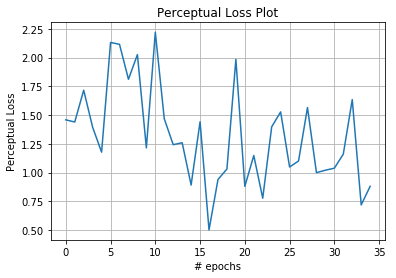

In [83]:
x = range(35)
plt.plot(x, [i*10 for i in loss_plot])
plt.title('Perceptual Loss Plot')
plt.xlabel('# epochs')
plt.ylabel('Perceptual Loss')
plt.grid()
plt.show()

In [114]:
import sys
import os.path
import glob
import cv2
import numpy as np
import torch


test_img_folder = '/content/drive/My Drive/val_LR/*.png'

test_model = RRDBNet(3, 3, 64, 23, gc=32, upscale=4, norm_type=None, act_type='leakyrelu', \
                        mode='CNA', upsample_mode='upconv')
test_model.load_state_dict(torch.load(path+'GeneratorX.pth'), strict=True)
test_model.eval()
for k, v in test_model.named_parameters():
    v.requires_grad = False
test_model = test_model.cuda()

idx = 0
print (glob.glob(test_img_folder))
for path in glob.glob(test_img_folder):
    print (path)
    idx += 1
    base = os.path.splitext(os.path.basename(path))[0]
    print(idx, base)
    # read image
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img * 1.0 / 255
    img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
    img_LR = img.unsqueeze(0)
    img_LR = img_LR.to(device)

    output = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
    output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
    output = (output * 255.0).round()
    cv2.imwrite('/content/drive/My Drive/DL/test.png', output)


[]


In [109]:
!ls '/content/drive/My Drive/DL/'

Dataset.zip    GeneratorX.pth  SR	 train_LR	     val_HR
Generator.pth  Octopus	       train_HR  Train_Valid_LR.zip  val_LR
